# Theory:

Try out the "auxiliary method" described in Platt. et al (DOI: 10.1063/5.0066013)

# Imports:

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import copy
import rescomp

# System:

### Lorenz iterator:

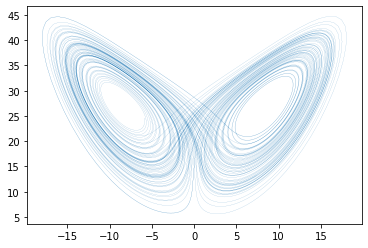

In [4]:
# Lorenz parameters:
dt_L = 0.01
starting_point_L = np.array([0, 1, 0])

# lorenz iterator:

def data_creation_function(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function(2, dt_L, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 10000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_L

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_L(x_last)

time_series = time_series_all[disc_steps:, :]

plt.plot(time_series[:, 0], time_series[:, 2], linewidth=0.1)

# RC prediction:

In [44]:
def create_esn(n_dim, x_dim, n_rad=0.1, n_avg_deg=6.0, w_in_scale=1.0, seed=45, activation_function="tanh_simple", leak_fct=0.99):
    esn = rescomp.ESNWrapper()
    np.random.seed(seed)
    esn.create_network(n_dim=n_dim, n_rad=n_rad, n_avg_deg=n_avg_deg,
                        n_type_flag="erdos_renyi", network_creation_attempts=10)
    esn.create_input_matrix(x_dim, w_in_scale=w_in_scale, w_in_sparse=True, w_in_ordered=False)
    esn.set_activation_function(activation_function, leak_fct=leak_fct)
    esn.reset_res_state()


    return esn

def auxillary_test(time_series, n_ens=10, n_rad=0.1, n_avg_deg=6.0, w_in_scale=1.0, n_dim=500, x_dim=3, activation_function="tanh_simple"):
    initial_conditions = np.random.randn(n_ens, n_dim)*1
    reservoir_states = np.empty((n_ens, time_series.shape[0], n_dim))
    for i_ens in range(n_ens):
        esn = create_esn(n_dim, x_dim, n_rad, n_avg_deg, w_in_scale, activation_function=activation_function)
        esn._last_r = initial_conditions[i_ens]
        reservoir_states[i_ens, :, :] = esn.synchronize(time_series, save_r=True)
    return reservoir_states

In [45]:
out = auxillary_test(time_series, n_ens=2, n_rad=5, n_avg_deg=20, w_in_scale=0.01, activation_function="sigmoid")

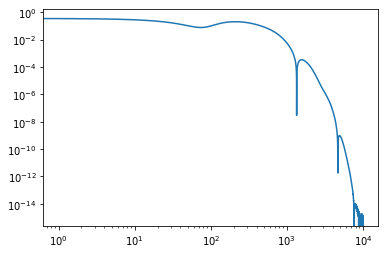

In [46]:
std = np.std(np.linalg.norm(out, axis=2), axis=0)
plt.loglog(std)

### try some settings:

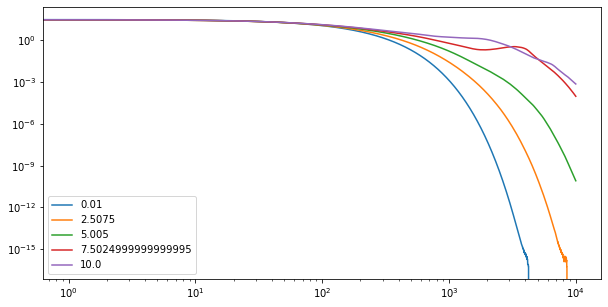

In [47]:
plt.figure(figsize=(10, 5))

n_rad_list = np.linspace(0.01, 10, 5)
for x in n_rad_list:
    out = auxillary_test(time_series, n_ens=2, n_rad=x, n_avg_deg=5, w_in_scale=0.01, activation_function="sigmoid")
    to_plot = np.linalg.norm(out[0, :, :] - out[1, :, :], axis=-1)
    plt.loglog(to_plot, label=f"{x}")
plt.legend()

C:\Users\Dennis\Documents\GitHub\rescomp\rescomp\esn.py:481: RuntimeWarning: divide by zero encountered in double_scalars
  self._network = ((self._n_rad / maximum) * self._network)


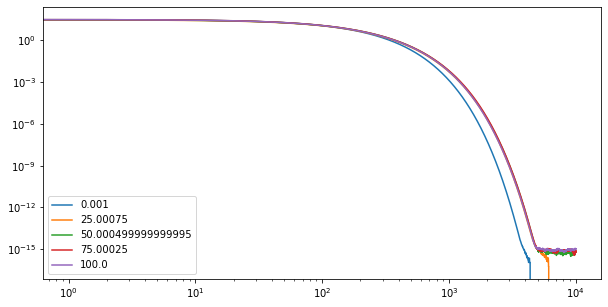

In [48]:
plt.figure(figsize=(10, 5))

n_avg_deg_list = np.linspace(0.001, 100, 5)
for x in n_avg_deg_list:
    out = auxillary_test(time_series, n_ens=2, n_rad=1, n_avg_deg=x, w_in_scale=0.01, activation_function="sigmoid")
    to_plot = np.linalg.norm(out[0, :, :] - out[1, :, :], axis=-1)
    plt.loglog(to_plot, label=f"{x}")
plt.legend()

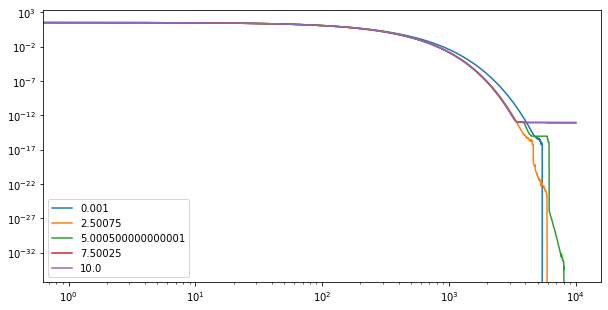

In [51]:
plt.figure(figsize=(10, 5))

w_in_scale_list = np.linspace(0.001, 10, 5)
for x in w_in_scale_list:
    out = auxillary_test(time_series, n_ens=2, n_rad=1, n_avg_deg=5, w_in_scale=x, activation_function="sigmoid")
    to_plot = np.linalg.norm(out[0, :, :] - out[1, :, :], axis=-1)
    plt.loglog(to_plot, label=f"{x}")
plt.legend()

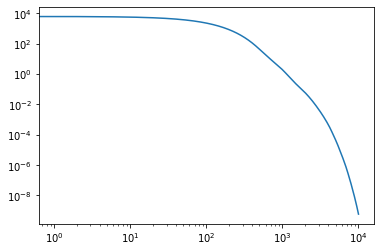

In [31]:
out = auxillary_test(time_series, n_ens=2, n_rad=5, n_avg_deg=5, w_in_scale=0.01, activation_function="sigmoid")
to_plot = np.linalg.norm(out[0, :, :] - out[1, :, :], axis=-1)
plt.loglog(to_plot)

In [20]:
n_rad_list = np.arange(0.01, 3, 1)
n_avg_deg_list = np.arange(0.01, 3, 1)

results = np.zeros((n_rad_list.size, n_avg_deg_list.size))

for i_rad, n_rad in enumerate(n_rad_list):
    for i_deg, n_avg_deg in enumerate(n_avg_deg_list):
        out = auxillary_test(time_series, n_ens=2, n_rad=n_rad, n_avg_deg=n_avg_deg, w_in_scale=0.1, activation_function="sigmoid")
        std_last = np.std(np.linalg.norm(out, axis=2), axis=0)[-1]
        results[i_rad, i_deg] = std_last

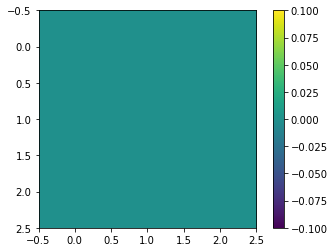

In [21]:
plt.imshow(results)
plt.colorbar()

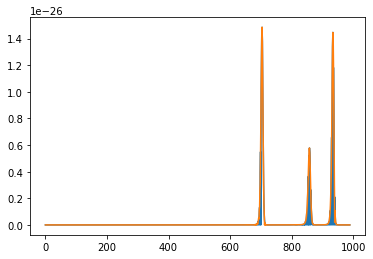

In [163]:
plt.plot(out[5, 10:, 0])
plt.plot(out[2, 10:, 0])

In [193]:
esn = create_esn(500, 3, n_avg_deg=6, n_rad=6)
network = esn.get_network()
out = esn.synchronize(time_series, save_r=True)

In [195]:
np.absolute(np.linalg.eig(network)[0])

array([6.00000000e+00, 6.00000000e+00, 5.81456999e+00, 5.69460426e+00,
       5.69460426e+00, 5.47889741e+00, 5.47889741e+00, 5.50843841e+00,
       5.50843841e+00, 5.96954329e+00, 5.80873753e+00, 5.80873753e+00,
       5.60781303e+00, 5.60781303e+00, 5.77147322e+00, 5.77147322e+00,
       5.59032434e+00, 5.59032434e+00, 5.54607681e+00, 5.54607681e+00,
       5.51546050e+00, 5.51546050e+00, 5.32745901e+00, 5.32745901e+00,
       5.45021498e+00, 5.40660015e+00, 5.40660015e+00, 4.93810276e+00,
       4.93810276e+00, 5.02036851e+00, 4.84626703e+00, 4.84626703e+00,
       5.06539041e+00, 5.06539041e+00, 5.05021141e+00, 5.05021141e+00,
       5.04520291e+00, 5.04520291e+00, 5.04070041e+00, 5.04070041e+00,
       4.98786661e+00, 4.98786661e+00, 5.06168409e+00, 5.06168409e+00,
       5.07721817e+00, 5.07721817e+00, 4.90248766e+00, 4.90248766e+00,
       4.88917609e+00, 4.88917609e+00, 4.89960699e+00, 4.89960699e+00,
       4.78467563e+00, 4.78467563e+00, 4.93741594e+00, 4.93741594e+00,
      

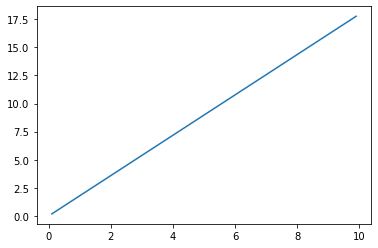

In [182]:
rad_list = np.arange(0.1, 10, 0.1)
ev = []
for ix, x in enumerate(rad_list):
    esn = create_esn(500, 3, n_avg_deg=6, n_rad=x)
    network = esn.get_network()
    ev.append(np.linalg.eigh(network)[0].max())

plt.plot(rad_list, ev)

In [188]:
esn = create_esn(500, 3, n_avg_deg=6, n_rad=6)
network = esn.get_network(as_array=False)
import scipy
n_dim = 500
eigenvals = scipy.sparse.linalg.eigs(
    network, k=1, v0=np.ones(n_dim),
    maxiter=1e3 * n_dim)[0]
np.absolute(eigenvals)

array([6.])

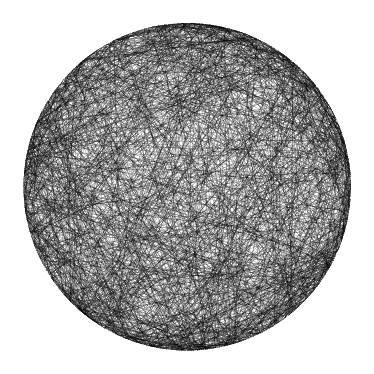

In [76]:
# Plot network:
import networkx as nx
G = nx.from_numpy_matrix(network)
plt.figure(figsize=(5, 5))
nx.draw_circular(G, arrowsize=15, with_labels=False, node_size=0, linewidth=0.5,  edge_cmap="hsv", width=0.2)

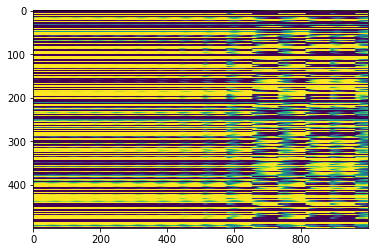

In [18]:
plt.imshow(out.T, aspect="auto")

In [ ]:
train_steps = 20000
sync_steps = 300

# create network:
esn = rescomp.ESNWrapper()

np.random.seed(42)
esn.create_network(n_dim=500, n_rad=0.1, n_avg_deg=6.0,
                    n_type_flag="erdos_renyi", network_creation_attempts=10)

x_dim = time_series.shape[1]
esn.create_input_matrix(x_dim, w_in_scale=1.0, w_in_sparse=True, w_in_ordered=False)

# train and predict:
y_pred, y_test = esn.train_and_predict(time_series, train_sync_steps=sync_steps, train_steps=train_steps,
                                       w_out_fit_flag="linear_and_square_r_alt")

# Compare real vs. predicted time_series:

In [ ]:
time = np.arange(0, y_pred.shape[0])*dt_L

## small times:

In [ ]:
# Simple: plot some coordinates
ix = 1
plt.plot(time, y_test[:, ix])
plt.plot(time, y_pred[:, ix])

plt.xlim(0, 15)

In [ ]:
# plot the error over time:
error = rescomp.measures.error_over_time(y_pred, y_test)
plt.plot(time, error)
plt.xlim(0, 15)

## Attractor measures:

### Probability Density Function:

In [ ]:
# PDE:
plt.figure(figsize=(15,5))

plt.subplot(131)
ix = 0

_, b, _ = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

plt.subplot(132)
ix = 1
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

plt.subplot(133)
ix = 2
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

### Fourier Spectrum:

In [ ]:
# Fourier Spectrum:
plt.figure(figsize=(10, 5))

x, y = rescomp.measures.fourier_spectrum(y_test, period=True)
plt.plot(x,y, label="real", alpha=0.5)
x, y = rescomp.measures.fourier_spectrum(y_pred, period=True)
plt.plot(x,y, label="pred", alpha=0.5)

# plt.xlim(-0.01, 0.02)
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.legend()

### Poincare Map:

In [ ]:
# Poincare Map:
ix = 0
mode="maxima"

plt.figure(figsize=(10, 5))

x, y = rescomp.measures.poincare_map(y_test, dimension=ix, mode=mode)
plt.scatter(x, y, label="real", s=1)

x, y = rescomp.measures.poincare_map(y_pred, dimension=ix, mode=mode)
plt.scatter(x, y, label="pred", s=1)

plt.legend()

### Correlation Dimension:

In [ ]:
sloap, N_r = rescomp.measures.dimension(y_test, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

sloap, N_r = rescomp.measures.dimension(y_pred, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"pred: {sloap}")

plt.legend()

### Lyapunov spectrum:

#### Rosenberg Algorithm:

In [ ]:
t_min, t_max = 0.6, 4
steps = 500

out = rescomp.measures.lyapunov_rosenstein(y_test, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"real: {coef[0]}")
plt.plot(x_fit, y_fit)

out = rescomp.measures.lyapunov_rosenstein(y_pred, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"pred: {coef[0]}")
plt.plot(x_fit, y_fit)

plt.legend()

#### QR decomposition:

In [ ]:
Nens = 5
N_dims = 5
np.random.seed(42)
starting_points = np.random.randn(Nens, 3)

In [ ]:
# iterator of reservoir:
def f_res(x):
    return esn._predict_step(x)

In [ ]:
out_real = rescomp.measures.calculate_divergence(f_L, starting_points=starting_points, T=10, tau=100, dt=dt_L, N_dims=N_dims, random_directions=True)

out_res = rescomp.measures.calculate_divergence(f_res, starting_points=starting_points, T=10, tau=100, dt=dt_L, N_dims=N_dims, random_directions=True)

In [ ]:
for out, label in zip((out_real, out_res), ("real", "pred")):
    y = np.log(out)
    y = np.mean(y, axis=-1)[:, 0]
    t = np.arange(0, y.size)*dt_L
    x_fit, y_fit, coef = rescomp.utilities._linear_fit(y, dt_L, t_min=0.01, t_max=0.6)
    plt.plot(x_fit, y_fit, label=f"{label}: {coef[0]}")
    plt.plot(t, y)
plt.legend()
plt.xlim(0, 1)

## Different inputs and synchronization:

In [ ]:
starting_point = np.array([-100, -100, -100])

# test lorenz iterator:
time_steps = 100000

time_series_2 = np.zeros((time_steps, 3))
time_series_2[0, :] = starting_point

res_results = np.zeros((time_steps, 500))

for i in range(1, time_steps):
    x_last = time_series_2[i - 1, :]
    time_series_2[i, :] = f_res(x_last)
    res_results[i, :] = esn._last_r

plt.plot(time_series_2[:, 0], time_series_2[:, 2], linewidth=0.3)

In [ ]:
plt.figure(figsize=(15, 9))
# plt.plot(res_results[:, 5])
# plt.plot(res_results[1000:-1000, 50], res_results[1000:-1000, 76], linewidth=0.3)
plt.scatter(res_results[1000:-1000, 53], res_results[1000:-1000, 52], s=0.5)

### PCA on reservoir states:

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(res_results)
X = pca.transform(res_results)
print(pca.explained_variance_ratio_)

print(pca.singular_values_)

In [ ]:
plt.plot(X[1000:, 0], X[1000:, 1], linewidth=0.1)

In [ ]:
# sloap, N_r = rescomp.measures.dimension(X[1000:, :], return_neighbours=True, nr_steps=10)
sloap, N_r = rescomp.measures.dimension(res_results, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

plt.legend()
